<a href="https://colab.research.google.com/github/MarkAvilin1/DS-and-ML/blob/main/NNwithGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Using GA to build a best structure of NN for this model!

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
from tensorflow.keras import utils 
import numpy as np 
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, Model 
from keras.layers import concatenate,Reshape, Input,Conv2DTranspose, Lambda, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, MaxPooling1D, Activation, GlobalMaxPooling1D, UpSampling1D
from keras.losses import MAE
from google.colab import files 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator 
import keras.backend as K
import random as random 
import numpy as np 
import matplotlib.pyplot as plt 
from PIL import Image 
import time
from tensorflow.keras.utils import plot_model
%matplotlib inline

In [ ]:
data = pd.read_csv('/content/traff.csv', header=None, decimal=',')
print(data.head())
print(type(data))

          0          1
0  1/1/2017  22,226.00
1  1/2/2017  29,593.00
2  1/3/2017  31,726.00
3  1/4/2017  32,684.00
4  1/5/2017  31,820.00
<class 'pandas.core.frame.DataFrame'>


In [ ]:
data = data.iloc[:,1]
print(data.head())

0    22,226.00
1    29,593.00
2    31,726.00
3    32,684.00
4    31,820.00
Name: 1, dtype: object


In [ ]:
for i in range(len(data)):
  data[i] = data[i].replace(',', '')
print(data.head())

0    22226.00
1    29593.00
2    31726.00
3    32684.00
4    31820.00
Name: 1, dtype: object


In [ ]:
data = np.array(data, dtype='float32')
max_data = max(data)
print(type(data), type(data[0]),  max_data, type(max_data))

<class 'numpy.ndarray'> <class 'numpy.float32'> 37665.0 <class 'numpy.float32'>


In [ ]:
all_data = data / max_data
all_data = all_data[:1000]
print(all_data[:5], type(all_data), all_data.shape)

[0.5900969  0.78568965 0.84232044 0.86775523 0.84481615] <class 'numpy.ndarray'> (1000,)


In [ ]:
X = np.reshape(all_data[0: 800], (-1, 1))
Y = np.reshape(all_data[800:], (-1, 1))
print(X.shape, X[:5])
print(Y.shape, Y[:5])

(800, 1) [[0.5900969 ]
 [0.78568965]
 [0.84232044]
 [0.86775523]
 [0.84481615]]
(200, 1) [[0.5782291 ]
 [0.56383914]
 [0.549396  ]
 [0.53200585]
 [0.59330946]]


In [ ]:
xLen = 60
def data_prepper(x, y, xLen=60):
  DataGen = TimeseriesGenerator(y, y,
                               length=xLen, sampling_rate=1,
                               batch_size=len(y)) 
  xVal = []
  yVal = []
  for i in DataGen:
    xVal.append(i[0])
    yVal.append(i[1])
  trainDataGen = TimeseriesGenerator(x, x,             
                               length=xLen, sampling_rate=1,
                               batch_size=20)                
  testDataGen = TimeseriesGenerator(y, y,
                               length=xLen, sampling_rate=1,
                               batch_size=20)
  return x, y, trainDataGen, testDataGen, np.array(xVal), np.array(yVal)

In [ ]:
train, test, train_gen, test_gen, xVal, yVal = data_prepper(X, Y)

print(train.shape, train[:5])
print(test.shape, test[:5])
print(len(train_gen))
print(len(test_gen))
print(len(xVal), type(xVal))
print(len(yVal), type(yVal))

(800, 1) [[0.5900969 ]
 [0.78568965]
 [0.84232044]
 [0.86775523]
 [0.84481615]]
(200, 1) [[0.5782291 ]
 [0.56383914]
 [0.549396  ]
 [0.53200585]
 [0.59330946]]
37
7
1 <class 'numpy.ndarray'>
1 <class 'numpy.ndarray'>


In [ ]:
# Функция рассчитываем результаты прогнозирования сети
def getPred(currModel, xVal, yVal):
  predVal = currModel.predict(xVal) * max_data
  yValUnscaled = yVal * max_data  
  return (predVal, yValUnscaled)

# Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, channel], 
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
# Функция расёта корреляции дух одномерных векторов
def correlate(a, b):
  ma = a.mean() 
  mb = b.mean() 
  mab = (a*b).mean() 
  sa = a.std() 
  sb = b.std() 
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

# Функция рисуем корреляцию прогнозированного сигнала с правильным
def autoCorr(channels, corrSteps, predVal, yValUnscaled, showGraf = True, returnData = False):
  for ch in channels:
    corr = []
    yLen = yValUnscaled.shape[0]
    for i in range(corrSteps):
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, ch]))
    own_corr = [] 
    for i in range(corrSteps):
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))
    if showGraf: 
      plt.plot(corr, label='предсказание на ' + str(ch+1) + ' шаг')
      plt.plot(own_corr, label='Эталон')
  if showGraf: 
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()
  if returnData: 
    return corr, own_corr

#Humen Model

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
37/37 [==============================] - 31s 13ms/step - loss: 0.3272 - val_loss: 0.0015
Epoch 2/50
37/37 [==============================] - 0s 8ms/step - loss: 0.0456 - val_loss: 0.0031
Epoch 3/50
37/37 [==============================] - 0s 8ms/step - loss: 0.0205 - val_loss: 0.0023
Epoch 4/50
37/37 [==============================] - 0s 8ms/step - loss: 0.0042 - val_loss: 0.0011
Epoch 5/50
37/37 [==============================] - 0s 8ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 6/50
37/37 [==============================] - 0s 8ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 7/50
37/37 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 8/50
37/37 [==============================] - 0s 9ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 9/50
37/37 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 10/50
37/37 [==============================] - 0s 8ms/step - loss: 0.0082 - val_loss: 0.0030
Epoch 11/50
37/37

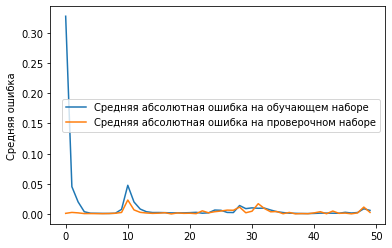

In [ ]:
shape = (xLen, 1)

inputs = Input(shape)
list_to_concat = [inputs]

x = BatchNormalization()(inputs)
maxPoolingSize = 3

x = Conv1D(2**6,3,padding='same')(x)
x = Activation('linear')(x)
list_to_concat.append(x)

x = Conv1D(2**6,5,padding='same')(x)
x = Activation('tanh')(x)
list_to_concat.append(x)

x = Conv1D(2**8,5,padding='same')(x)
x = Activation('linear')(x)
list_to_concat.append(x)

for i in range(len(list_to_concat)):
  list_to_concat[i]=Flatten()(list_to_concat[i])

fin = concatenate(list_to_concat)
fin = Dense(2**6)(fin)
fin = Activation('linear')(fin)

fin = Dense(1)(fin)

modelC = Model(inputs, fin)

modelC.compile(loss="mse", optimizer=Adam(lr=1e-4))

humen_model = modelC.fit_generator(train_gen,
                    epochs=50, 
                    verbose=1,
                    validation_data=test_gen)
plt.plot(humen_model.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(humen_model.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
modelC.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 1)]      0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 60, 1)        4           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 60, 64)       256         batch_normalization[0][0]        
__________________________________________________________________________________________________
activation (Activation)         (None, 60, 64)       0           conv1d[0][0]                     
______________________________________________________________________________________________

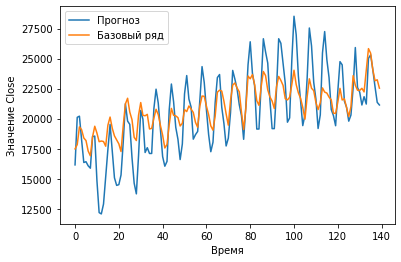

In [ ]:
currModel = modelC #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0]) #Прогнозируем данные

# Отображаем графики
showPredict(0, 400, 0, predVal, yValUnscaled)

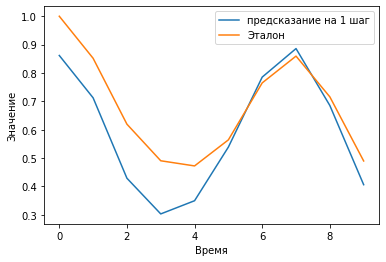

In [ ]:
autoCorr([0], 10, predVal, yValUnscaled)

#GA Model

In [ ]:
# Создаём сеть (net - список параметров)
def createConvNet(net):  
  makeFirstNormalization = net[0] 
  maxPoolKernel = net[1]          
  firstConvSize = 2 ** net[2]     
  firstConvKernel = net[3]        
  activation1 = net[4]            
  makeConv2 = net[5]              
  secondConvSize = 2 ** net[6]    
  secondConvKernel = net[7]       
  makePool2 = net[8]              
  activation2 = net[9]            
  makeConv3 = net[10]            
  thirdConvSize = 2 ** net[11]    
  thirdConvKernel = net[12]       
  makePool3 = net[13]             
  activation3 = net[14]           
  makeConv4 = net[15]             
  fourthConvSize = 2 ** net[16]   
  fourthConvKernel = net[17]      
  makePool4 = net[18]             
  activation4 = net[19]           
  makeConv5 = net[20]             
  fifthConvSize = 2 ** net[21]    
  fifthConvKernel = net[22]       
  makePool5 = net[23]             
  activation5 = net[24]           
  makeDense = net[25]             
  denseSize = 2 ** net[26]        
  activation6 = net[27]           
  shape = (xLen, 1)               
  inputs = Input(shape)           
  activation_list = ['linear','relu','elu','softmax','sigmoid']
  if (makeFirstNormalization):    
    x = BatchNormalization()(inputs)
    x = Conv1D(firstConvSize,firstConvKernel, padding ='same')(x)
    x = Activation(activation_list[activation1])(x)
  else:                           
    x = Conv1D(firstConvSize,firstConvKernel, padding ='same')(inputs)
    x = Activation(activation_list[activation1])(x)
  list_to_concat = [inputs]     
  for i in range(4):              
    if net[5+5*i]!=0:             
      x = Conv1D(net[6+5*i],net[7+5*i], padding ='same')(x)
      x = Activation(activation_list[net[5*i+4]])(x)
      x = Reshape((-1,1))(x)
      if net[8+5*i]!=0:           
        x = MaxPooling1D(maxPoolKernel)(x)
        list_to_concat.append(x)  
      else:
        list_to_concat.append(x) 
      list_to_concat.append(x)    
  for i in range(len(list_to_concat)):    
    if list_to_concat[i].shape != (None,0,1):
      list_to_concat[i] = Flatten()(list_to_concat[i]) 
    else:
      break
  if len(list_to_concat) != 1:
     fin = concatenate(list_to_concat)
  else:
    fin = x
    fin = Flatten()(fin)
  if makeDense!=0:
    fin = Dense(denseSize)(fin)
    fin = Activation(activation_list[activation6])(fin)
  fin = Dense(1)(fin)
  model = Model(inputs, fin)  
  return model                


# Функция вычисления резульата работы сети
def evaluateNet(net, ep, verb):
  val = 0
  model = createConvNet(net)
  model.compile(optimizer=Adam(lr=1e-4),
                  loss='mse')
  ga_model = model.fit_generator(train_gen,
                    epochs=5, 
                    verbose=verb,
                    validation_data=test_gen)
  (predVal, yValUnscaled) = getPred(model, xVal[0], yVal[0]) 
  corr, own_corr = autoCorr([0], 5, predVal, yValUnscaled, showGraf = False, returnData = True)
  val = MAE(corr, own_corr).numpy() + ga_model.history["val_loss"][-1] 
  return val, model 


# Функция создания списка случайных параметров
def createRandomNet():
  net = []
  net.append(random.randint(0,1)) 
  net.append(random.randint(2,4)) 
  net.append(random.randint(3,10)) 
  net.append(random.randint(3,7))  
  net.append(random.randint(0,4))  
  net.append(random.randint(0,1))  
  net.append(random.randint(3,10)) 
  net.append(random.randint(3,7))  
  net.append(random.randint(0,1))  
  net.append(random.randint(0,4))  
  net.append(random.randint(0,1))  
  net.append(random.randint(3,10)) 
  net.append(random.randint(3,7))  
  net.append(random.randint(0,1))  
  net.append(random.randint(0,4))  
  net.append(random.randint(0,1))  
  net.append(random.randint(3,10)) 
  net.append(random.randint(3,7))  
  net.append(random.randint(0,1))  
  net.append(random.randint(0,4)) 
  net.append(random.randint(0,1))  
  net.append(random.randint(3,10)) 
  net.append(random.randint(3,7))  
  net.append(random.randint(0,1))  
  net.append(random.randint(0,4)) 
  net.append(random.randint(0,1))  
  net.append(random.randint(3,10)) 
  net.append(random.randint(0,4))  
  return net

In [ ]:
n = 20                    
nsurv = 7                 
nnew = n - nsurv          
l = 28                    
epohs = 10                
mut = 0.4                 
popul = []                
val = []    

for i in range(n):
  popul.append(createRandomNet())  
for it in range(epohs):   
  val = []                
  curr_time = time.time()
  for i in range(n):      
    bot = popul[i]        
    f, model_sum = evaluateNet(bot, 3, 0) 
    val.append(f) 
  sval = sorted(val, reverse=0) 

  print(it, time.time() - curr_time,  " ", sval[0:5], popul[:5]) 
  
  newpopul = []                        
  for i in range(nsurv):                
    index = val.index(sval[i])         
    newpopul.append(popul[index])       
  for i in range(nnew):                
    indexp1 = random.randint(0, nsurv - 1)
    indexp2 = random.randint(0, nsurv - 1) 
    botp1 = newpopul[indexp1]           
    botp2 = newpopul[indexp2]          
    newbot = []                         
    net4Mut = createRandomNet()         
    for j in range(l):                       
      x = 0      
      pindex = random.random()         
      if pindex < 0.5:
        x = botp1[j]
      else:
        x = botp2[j]
      if (random.random() < mut):
        x = net4Mut[j]        
      newbot.append(x)                  
    newpopul.append(newbot)              
  popul = newpopul                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


0 51.9233455657959   [0.10814751614816487, 0.14242104976437986, 0.1511116981273517, 0.1548138747457415, 0.1601856095949188] [[0, 2, 3, 5, 0, 1, 5, 6, 0, 0, 1, 8, 7, 0, 2, 0, 5, 4, 1, 1, 1, 3, 5, 1, 4, 0, 8, 0], [0, 2, 7, 3, 4, 1, 8, 6, 0, 4, 0, 6, 4, 0, 4, 1, 7, 3, 0, 3, 0, 3, 6, 1, 3, 0, 10, 1], [0, 3, 4, 4, 0, 1, 7, 7, 1, 1, 0, 10, 6, 0, 2, 0, 8, 4, 1, 1, 0, 10, 6, 1, 4, 1, 6, 0], [0, 4, 4, 5, 0, 1, 10, 7, 0, 3, 0, 4, 7, 0, 3, 1, 9, 3, 1, 3, 0, 5, 6, 1, 1, 1, 8, 0], [0, 4, 9, 4, 3, 1, 10, 7, 0, 2, 0, 9, 5, 1, 4, 0, 5, 5, 1, 4, 1, 6, 3, 0, 2, 1, 9, 4]]
1 51.498539686203   [0.10619816707912832, 0.11247433617245406, 0.14321699657011777, 0.14477149536833167, 0.17899454990401864] [[0, 4, 4, 5, 0, 1, 10, 7, 0, 3, 0, 4, 7, 0, 3, 1, 9, 3, 1, 3, 0, 5, 6, 1, 1, 1, 8, 0], [0, 3, 3, 6, 0, 0, 3, 4, 1, 3, 1, 5, 5, 1, 1, 1, 4, 7, 1, 4, 0, 7, 4, 0, 2, 1, 10, 0], [0, 2, 3, 5, 0, 1, 5, 6, 0, 0, 1, 8, 7, 0, 2, 0, 5, 4, 1, 1, 1, 3, 5, 1, 4, 0, 8, 0], [0, 4, 8, 6, 4, 0, 5, 5, 1, 1, 1, 7, 7, 1, 2, 1, 6, 4

In [ ]:
model = createConvNet(popul[0])
model.summary()

Model: "model_675"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_676 (InputLayer)          [(None, 60, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_2056 (Conv1D)            (None, 60, 8)        32          input_676[0][0]                  
__________________________________________________________________________________________________
activation_2467 (Activation)    (None, 60, 8)        0           conv1d_2056[0][0]                
__________________________________________________________________________________________________
conv1d_2057 (Conv1D)            (None, 60, 4)        196         activation_2467[0][0]            
__________________________________________________________________________________________

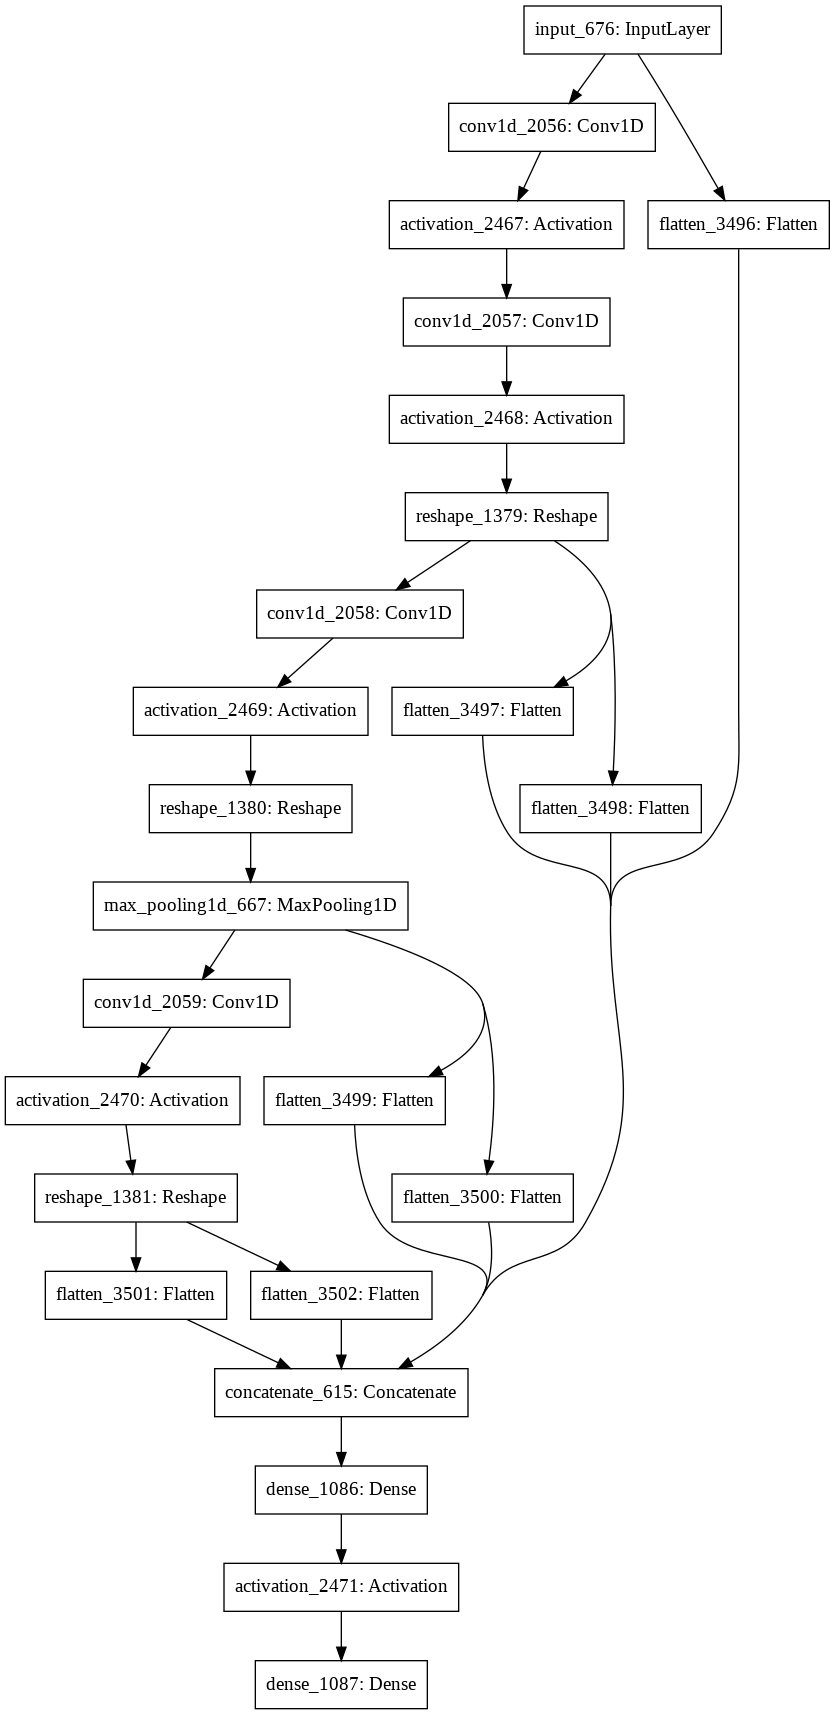

In [ ]:
plot_model(model)

In [ ]:
model.compile(optimizer=Adam(lr=1e-4),
                loss='mse')

ga_model = model.fit_generator(train_gen,
                    epochs=50, 
                    validation_data=test_gen)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
37/37 [==============================] - 1s 15ms/step - loss: 0.0531 - val_loss: 0.0022
Epoch 2/50
37/37 [==============================] - 0s 8ms/step - loss: 0.0062 - val_loss: 0.0099
Epoch 3/50
37/37 [==============================] - 0s 9ms/step - loss: 0.0075 - val_loss: 0.0049
Epoch 4/50
37/37 [==============================] - 0s 8ms/step - loss: 0.0084 - val_loss: 6.5653e-04
Epoch 5/50
37/37 [==============================] - 0s 8ms/step - loss: 0.0025 - val_loss: 5.5940e-04
Epoch 6/50
37/37 [==============================] - 0s 8ms/step - loss: 0.0044 - val_loss: 0.0046
Epoch 7/50
37/37 [==============================] - 0s 8ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 8/50
37/37 [==============================] - 0s 8ms/step - loss: 0.0026 - val_loss: 0.0040
Epoch 9/50
37/37 [==============================] - 0s 8ms/step - loss: 0.0041 - val_loss: 0.0076
Epoch 10/50
37/37 [==============================] - 0s 8ms/step - loss: 0.0031 - val_loss: 5.3416e-04
Epoch 

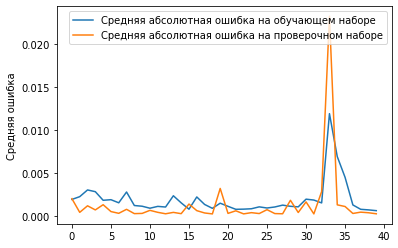

In [ ]:
plt.plot(ga_model.history['loss'][10:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(ga_model.history['val_loss'][10:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

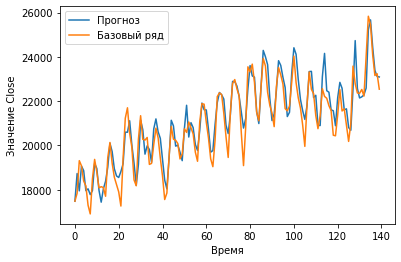

In [ ]:
currModel = model 
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0]) 

showPredict(0, 400, 0, predVal, yValUnscaled)

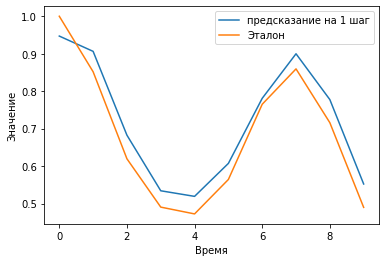

In [ ]:
autoCorr([0], 10, predVal, yValUnscaled)

In [ ]:
print(f"""
Humen model loss = {humen_model.history['loss'][-1]} => GA model loss = {ga_model.history['loss'][-1]}
Humen model val_loss = {humen_model.history['val_loss'][-1]} => GA model val_loss = {ga_model.history['val_loss'][-1]}
""")


Humen model loss = 0.0064011625945568085 => GA model loss = 0.000649568741209805
Humen model val_loss = 0.0030952468514442444 => GA model val_loss = 0.0002848648000508547



#Вывод: 
Нейронные сети которые были созданы с помощью генетического алгоритма дали результат лучше чем обычной модели!